In [1]:
# dates.py
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

TODAY = dt.today().date()
NYEARS = TODAY.year - 2012 + 1


def end_date(year):
    return TODAY - relativedelta(years=year)


def start_date(year, days):
    return TODAY - relativedelta(years=year, days=days)


def date_list(days):
    dates = []
    for year in range(0, NYEARS):
        end = end_date(year)
        start = start_date(year, days)
        yr = end.year
        dates.append((start, end, yr))
    return dates

In [2]:
date_list(days=7)

[(datetime.date(2021, 5, 14), datetime.date(2021, 5, 21), 2021),
 (datetime.date(2020, 5, 14), datetime.date(2020, 5, 21), 2020),
 (datetime.date(2019, 5, 14), datetime.date(2019, 5, 21), 2019),
 (datetime.date(2018, 5, 14), datetime.date(2018, 5, 21), 2018),
 (datetime.date(2017, 5, 14), datetime.date(2017, 5, 21), 2017),
 (datetime.date(2016, 5, 14), datetime.date(2016, 5, 21), 2016),
 (datetime.date(2015, 5, 14), datetime.date(2015, 5, 21), 2015),
 (datetime.date(2014, 5, 14), datetime.date(2014, 5, 21), 2014),
 (datetime.date(2013, 5, 14), datetime.date(2013, 5, 21), 2013),
 (datetime.date(2012, 5, 14), datetime.date(2012, 5, 21), 2012)]

In [3]:
# sql-query.py
import requests
from datetime import datetime as dt

BASE_URL = 'https://api.resourcewatch.org/v1/query'
DATA_ID = '1c72bdb6-0f93-4319-bf47-e2f23c5f0e37'    # Daily change (ADM2)


def date_sql(dates):
    sql = ""
    i = 0
    # dates = date_list(days=days)
    for start, end, year in dates:
        if i != 0:
            sql += " OR "
        sql += "alert__date >= '" + start.strftime('%Y-%m-%d') + "' AND alert__date <= '" + end.strftime('%Y-%m-%d') + "'"
        i += 1
    return sql


# Use the daily database table
def build_query(iso, dates, printq=False):
    q = (
        "SELECT iso, adm1, adm2, wdpa_protected_area__iucn_cat, is__umd_regional_primary_forest_2001, " +
        "is__peatland, is__ifl_intact_forest_landscape_2016, alert__date, SUM(alert__count) " +
        # "SELECT iso, adm1, adm2, alert__date, SUM(alert__count) " +
        "as alert__count, confidence__cat " +
        "FROM mytable " +
        f"WHERE iso='{iso}' AND confidence__cat='h' AND ({date_sql(dates)}) " +
        # f"WHERE iso='{iso}' AND adm1={adm1} AND confidence__cat='h' AND ({date_sql(days)}) " +
        "GROUP BY iso, adm1, adm2, wdpa_protected_area__iucn_cat, is__umd_regional_primary_forest_2001, " +
        "is__peatland, is__ifl_intact_forest_landscape_2016, alert__date"
    )
    if printq:
        print(q)

    return q


def query_params(q):
    params = {
        'sql': q
    }
    return params


def send_request(iso, dates, printq=False):
    q = build_query(iso, dates, printq)
    # q = "SELECT * FROM mytable WHERE iso='IND' AND confidence__cat='h'"
    p = query_params(q)
    r = requests.get(BASE_URL + '/' + DATA_ID, params=p)
    
    if r.status_code == 200:
        return r.json()['data']

    else:
        print('Something went wrong...')
        print('Status code: ', r.status_code)
        print('Error message: ', r.json()['errors'][0]['detail'])

In [4]:
dates = date_list(days=7)
data = send_request('IND', dates)

In [5]:
data[:3]

[{'alert__date': '2015-05-21',
  'alert__count': 11,
  'is__ifl_intact_forest_landscape_2016': 'false',
  'is__peatland': 'false',
  'is__umd_regional_primary_forest_2001': 'false',
  'wdpa_protected_area__iucn_cat': '0',
  'adm2': 8,
  'adm1': 28,
  'iso': 'IND'},
 {'alert__date': '2012-05-14',
  'alert__count': 1,
  'is__ifl_intact_forest_landscape_2016': 'false',
  'is__peatland': 'false',
  'is__umd_regional_primary_forest_2001': 'false',
  'wdpa_protected_area__iucn_cat': '0',
  'adm2': 8,
  'adm1': 28,
  'iso': 'IND'},
 {'alert__date': '2012-05-15',
  'alert__count': 2,
  'is__ifl_intact_forest_landscape_2016': 'false',
  'is__peatland': 'false',
  'is__umd_regional_primary_forest_2001': 'false',
  'wdpa_protected_area__iucn_cat': '0',
  'adm2': 8,
  'adm1': 28,
  'iso': 'IND'}]

In [6]:
# calculate-significance.py
from pandas import DataFrame, to_datetime, Index

CYEAR = dt.today().year


def assign_season(date, dates):
    for start, end, year in dates:
        if start <= date <= end:
            return year


def make_df(data, dates):
    df = DataFrame(data)
    df['season'] = (
        to_datetime(df['alert__date'])
            .apply(assign_season, args=(dates, ))
    )
    return df


def adm1_seasonal_summary(df, adm1):
    keep_cols = [
        "iso", "adm1", "adm2", "alert__count", "season"
    ]
    country = df['iso'][0]
    i = Index(range(2012, CYEAR + 1))
    adm1_df = df[df['adm1']==adm1]
    adm1_summary = (
        adm1_df[keep_cols]
            .groupby('season')
            # .agg({'alert__count': 'sum'})
            .agg(all_count=('alert__count', 'sum'))
            .reindex(i, fill_value=0)
    )
    return country, adm1, adm1_summary


def adm2_seasonal_summary(df, adm1, adm2):
    country = df['iso'][0]
    adm1 = df[df['adm1']==adm1]['adm1'].iloc[0]
    i = Index(range(2012, CYEAR + 1))
    adm2_df = df[(df['adm1']==adm1) & (df['adm2']==adm2)]
    adm2_summary = (
        adm2_df
            .groupby('season')
            .agg({'alert__count': 'sum'})
            .reindex(i, fill_value=0)
    )
    return country, adm1, adm2, adm2_summary


# def calculate_significance(seasonal_summary):
#     x = seasonal_summary.loc[CYEAR].item()
#     mu = seasonal_summary['alert__count'].mean().item()
#     sd = seasonal_summary['alert__count'].std().item()
#     if sd:
#         significance_score = (x - mu) / sd
#     else:
#         significance_score = 0
#     return significance_score, x


def adm1_significance(df, adm1):
    country, adm1, adm1_summary = adm1_seasonal_summary(df, adm1)
    significance_score, current_alerts = calculate_significance(adm1_summary)
    return (country, adm1, significance_score, current_alerts) 


def adm2_significance(df, adm1, adm2):
    country, adm1, adm2, adm2_summary = adm2_seasonal_summary(df, adm1, adm2)
    significance_score, current_alerts = calculate_significance(adm2_summary)
    return (country, adm1, adm2, significance_score, current_alerts)

# Calculate summaries separately and then join all counts together
# Think of a better way to do this ^ (good enough for now...)
# Should probably change wdpa category so it is true/false

# Make this a new utils package
i = Index(range(2012, CYEAR + 1))

def all_count(adm1_df):
    keep_cols = [
        "iso", "adm1", "adm2", "alert__count", "season"
    ]
    
    all_summary = (
        adm1_df[keep_cols]
            .groupby('season')
            .agg(all_count=('alert__count', 'sum'))
            .reindex(i, fill_value=0)
    )

    return all_summary

def wdpa_count(adm1_df):
    keep_cols = [
        "iso", "adm1", "adm2", "alert__count", "season"
    ]
    
    adm1_wdpa = adm1_df.loc[
        (adm1_df['wdpa_protected_area__iucn_cat'] != '0') &
        (adm1_df['wdpa_protected_area__iucn_cat'] != 'Other Category')
    ]
    
    wdpa_summary = (
        adm1_wdpa[keep_cols]
            .groupby('season')
            .agg(wdpa_count=('alert__count', 'sum'))
            .reindex(i, fill_value=0)
    )

    return wdpa_summary

def primary_count(adm1_df):
    keep_cols = [
        "iso", "adm1", "adm2", "is__umd_regional_primary_forest_2001", "is__ifl_intact_forest_landscape_2016", "alert__count", "season"
    ]
    
    adm1_primary = adm1_df.loc[
        (adm1_df['is__umd_regional_primary_forest_2001'] == "true") |
        (adm1_df['is__ifl_intact_forest_landscape_2016'] == "true")
    ]

    primary_summary = (
        adm1_primary[keep_cols]
            .groupby('season')
            .agg(primary_count=('alert__count', 'sum'))
            .reindex(i, fill_value=0)
    )

    return primary_summary

def peat_count(adm1_df):
    keep_cols = [
        "iso", "adm1", "adm2", "is__peatland", "alert__count", "season"
    ]
    
    adm1_peat = adm1_df[adm1_df['is__peatland'] == "true"]

    peat_summary = (
        adm1_peat[keep_cols]
            .groupby('season')
            .agg(peat_count=('alert__count', 'sum'))
            .reindex(i, fill_value=0)
    )
    
    return peat_summary

In [7]:
CYEAR = 2021


def calculate_significance(seasonal_summary, col):
    x = seasonal_summary[col].loc[CYEAR].item()
    mu = seasonal_summary[col].mean().item()
    sd = seasonal_summary[col].std().item()

    if sd:
        significance_score = (x - mu) / sd
    else:
        significance_score = 0

    return significance_score

In [60]:
# Probably uses too much memory now
# Data should only be stored at the district level and then
# aggegated up if needed for region or country levels

import pandas as pd
import numpy as np


CYEAR = 2021


def get_regions_and_districts(country):
    regions = []
    districts = []

    region_ids = list(country.region_ids)

    while region_ids:
        region_id = region_ids.pop()
        region = Region(country, region_id)
        regions.append(region)
        districts += get_districts(region)

    return regions, districts


def add_proportions(final_summary):
    all_alerts = final_summary["all_count"]
    final_summary["wdpa_prop"] = final_summary["wdpa_count"] / all_alerts
    final_summary["primary_prop"] = final_summary["primary_count"] / all_alerts
    final_summary["peat_prop"] = final_summary["peat_count"] / all_alerts

    return final_summary.replace(np.nan, 0)


# Need to make this and subsequent functions flexible enough to handle regional or district data
def combine_season_summaries(region_data):
    wdpa_summary = wdpa_count(region_data)
    primary_summary = primary_count(region_data)
    peat_summary = peat_count(region_data)
    all_summary = all_count(region_data)

    season_summaries = [wdpa_summary, primary_summary, peat_summary, all_summary]

    return season_summaries


# Calculate standard score (i.e., significance score)
def get_std_score(season_data, year, col):
    x = season_data.loc[year][col].item()
    moo = season_data[col].mean().item()
    sd = season_data[col].std().item()

    if sd:
        std_score = (x - moo) / sd
    else:
        std_score = 0

    return std_score


def get_std_scores(season_data):
    d = {}

    for column in season_data.columns[:4]:  # Limit to counted variables
        name = column.split('_')  # Split column name
        name[1] = 'std_score'  # Replace 'count' with 'std_score'
        key = '_'.join(name)  # Join together column name
        d[key] = get_std_score(season_data, CYEAR, column)

    return d


def make_region_row(region):
    row = {'country': region.country, 'region': region.id}
    row |= region.counts | region.std_scores

    return pd.Series(row)


def make_district_row(district):
    row = {'country': district.country, 'region': district.region, 'district': district.id}
    row |= district.counts | district.std_scores

    return pd.Series(row)

# Store region id as the key in the dictionary
class Country:
    def __init__(self, df):
        self.id = df.iso[0]
        self.data = df
        self.region_ids = set(df.adm1)
        self.regions, self.districts = get_regions_and_districts(self)
        self.region_summary = pd.DataFrame([make_region_row(region) for region in self.regions])
        self.district_summary = pd.DataFrame([make_district_row(district) for district in self.districts])
    # regions, districts = get_regions_and_districts(country)

    # def add_regions(self):
    #     regions = [Region(self, region_id) for region_id in self.region_ids]
        
    #     return regions


    # def region_summary(self):
    #     self.region_data = pd.DataFrame([make_region_row(region) for region in regions])

    # def district_summary(self):
    #     self.district_data = pd.DataFrame([make_district_row(district) for district in districts])
    
    def __repr__(self):
        out =(
            f"country: {self.id}\n" +
            f"regions: {self.region_ids}"
        )
        
        return out

class Region:
    def __init__(self, country, region_id):
        self.country = country.id
        self.id = region_id
        self.data = country.data[country.data['adm1'] == region_id]
        self.districts = set(self.data.adm2)
        self.season_data = self.season_summary()
        self.counts = self.season_data.loc[CYEAR].to_dict()
        self.std_scores = get_std_scores(self.season_data)


    # Seasonal summary for selected time period
    def season_summary(self):
        summaries = combine_season_summaries(self.data)
        summaries = add_proportions(pd.concat(summaries, axis=1))

        return summaries

    def get_historical(self):
        q = f"SELECT * FROM mytable WHERE iso='{self.country}' AND adm1={self.id}"
        r = requests.get(BASE_URL + '/' + DATA_ID, params = {'sql': q})
        if r.status_code == 200:
            return r.json()['data']

        else:
            print('Something went wrong...')
            print('Status code: ', r.status_code)
            print('Error message: ', r.json()['errors'][0]['detail'])

    def __repr__(self):
        out =(
            f"country: {self.country}\n" +
            f"region: {self.id}\n" +
            f"districts: {self.districts}"
        )

        return out

class District:
    def __init__(self, region, district_id):
        self.country = region.country
        self.region = region.id
        self.id = district_id
        self.data = region.data[region.data['adm2'] == district_id]
        self.season_data = self.season_summary()
        self.counts = self.season_data.loc[CYEAR].to_dict()
        self.std_scores = get_std_scores(self.season_data)


    # Seasonal summary for selected time period
    def season_summary(self):
        summaries = combine_season_summaries(self.data)
        summaries = add_proportions(pd.concat(summaries, axis=1))

        return summaries


    def __repr__(self):
        out =(
            f"country: {self.country}\n" +
            f"region: {self.region}\n" +
            f"district: {self.id}"
        )

        return out

In [49]:
def get_districts(region):
    districts = []
    for district in region.districts:
        district_id = district
        district = District(region, district_id)
        districts.append(district)
    return districts


# def get_regions_and_districts(country):
#     regions = []
#     districts = []

#     while country.regions:

#         region_id = country.regions.pop()
#         region = Region(country, region_id)
#         districts += get_districts(region)
#         regions.append(region)

#     return regions, districts

In [50]:
data = send_request('IND', dates)

In [51]:
df = make_df(data, dates)
country = Country(df)

In [52]:
# set(country.data.adm1)
country

country: IND
regions: {2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 32, 34, 35, 36}

In [53]:
country.district_summary.sort_values(by=['all_std_score'], ascending=False).head(3)

,country,region,district,wdpa_count,primary_count,peat_count,all_count,wdpa_prop,primary_prop,peat_prop,wdpa_std_score,primary_std_score,peat_std_score,all_std_score
57,IND,34,58,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2.84605
36,IND,34,31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2.84605
18,IND,34,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,2.84605


In [54]:
def gadm_countries(file='gadm_adm1.csv'):
    keep_cols = ['GID_0', 'NAME_0', 'GID_1', 'NAME_1']
    gadm_df = pd.read_csv(file, usecols=keep_cols)
    iso_list = gadm_df.GID_0.unique()
    return iso_list

In [55]:
data = send_request('ALA', dates)
data

[]

In [71]:
#
#
#

# iso_list = ['IND']
iso_list = ['IND', 'BRA']
# iso_list = gadm_countries()

dates = date_list(days=7)

counter = 1
countries = {}
for country in iso_list:
    print(f'Working on {country} ({counter}/{len(iso_list)})...')
    data = send_request(country, dates)
    if data:
        df = make_df(data, dates)
        countries[country] = Country(df)

    else:
        pass

    counter += 1

countries

#
#
#

Working on IND (1/2)...
Working on BRA (2/2)...


{'IND': country: IND
 regions: {2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 32, 34, 35, 36},
 'BRA': country: BRA
 regions: {1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}}

In [57]:
countries['IND'].region_summary.head(3)

,country,region,wdpa_count,primary_count,peat_count,all_count,wdpa_prop,primary_prop,peat_prop,wdpa_std_score,primary_std_score,peat_std_score,all_std_score
0,IND,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0,-0.474342
1,IND,35,0.0,0.0,0.0,3.0,0.0,0.0,0.0,-0.514496,-0.316228,0,-0.808612
2,IND,34,0.0,0.0,0.0,17.0,0.0,0.0,0.0,-0.474342,-0.316228,0,-0.521466


In [86]:
# Combine regional data for all countries
all_regions = pd.concat([countries[country].region_summary for country in countries])
all_districts = pd.concat([countries[country].district_summary for country in countries])

In [45]:
# Sort and export this to excel...
def write_results(all_regions, all_districts):
    print('Writing results...', end="")
    today = dt.today().date()
    filename = f'viirs_std_scores_7days_' + today.strftime('%Y%m%d') + '.xlsx'
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    all_regions.to_excel(writer, sheet_name='regions', index=False)
    all_districts.to_excel(writer, sheet_name='districts', index=False)
    writer.save()
    print('done')

In [46]:
write_results(all_regions, all_districts)

Writing results...done


In [63]:
t = countries["IND"].regions[0].get_historical()

In [65]:
pd.DataFrame(t)

,iso,adm1,adm2,alert__date,confidence__cat,wdpa_protected_area__iucn_cat,is__umd_regional_primary_forest_2001,is__birdlife_alliance_for_zero_extinction_site,is__birdlife_key_biodiversity_area,is__landmark_land_right,...,is__idn_forest_moratorium,is__gfw_oil_palm,idn_forest_area__type,per_forest_concession__type,is__gfw_oil_gas,is__gmw_mangroves_2016,is__ifl_intact_forest_landscape_2016,bra_biome__name,alert__count,_id
0,IND,36,17,2018-05-11,n,0,False,False,False,False,...,False,False,0,0,False,False,False,0,3,y0VBa3UBNTYQFbWCsoyl
1,IND,36,16,2018-11-28,n,0,False,False,False,False,...,False,False,0,0,False,False,False,0,1,X0VBa3UBNTYQFbWCspqm
2,IND,36,3,2012-03-31,n,0,False,False,False,False,...,False,False,0,0,False,False,False,0,2,UstBa3UBkyHUmd1wsqH7
3,IND,36,3,2013-02-07,n,0,False,False,False,False,...,False,False,0,0,False,False,False,0,4,YstBa3UBkyHUmd1wsqH7
4,IND,36,2,2014-03-21,l,0,False,False,False,False,...,False,False,0,0,False,False,False,0,1,TkVBa3UBNTYQFbWCssGp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796,IND,36,17,2021-05-16,n,0,False,False,False,False,...,False,False,0,0,False,False,False,Not applicable,4,QHHkeHkBTfpRoB11t8r9
24797,IND,36,18,2021-05-16,n,0,False,False,False,False,...,False,False,0,0,False,False,False,Not applicable,1,F3HkeHkBTfpRoB11t9T-
24798,IND,36,17,2021-05-16,l,0,False,False,False,False,...,False,False,0,0,False,False,False,Not applicable,1,23HkeHkBTfpRoB11t9X_
24799,IND,36,17,2021-05-17,n,0,False,False,False,False,...,False,False,0,0,False,False,False,Not applicable,2,1h4JfnkBzN-Opm6kSZmU


In [ ]:
def determine_fire_season():
    pass

In [84]:
t = countries['BRA'].regions[15].data
t[t['season'] == 2021].alert__count.sum()

57

In [21]:
all_regions.head()

,country,region,wdpa_count,primary_count,peat_count,all_count,wdpa_prop,primary_prop,peat_prop,wdpa_std_score,primary_std_score,peat_std_score,all_std_score
0,IND,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0,-0.474342
1,IND,35,0.0,0.0,0.0,3.0,0.0,0.0,0.0,-0.514496,-0.316228,0,-0.808612
2,IND,34,0.0,0.0,0.0,17.0,0.0,0.0,0.0,-0.474342,-0.316228,0,-0.521466
3,IND,32,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.000000,0.000000,0,-0.862206
4,IND,31,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0,-0.172488


In [87]:
all_districts[all_districts['all_count'] > 10].sort_values('all_std_score', ascending=False)

,country,region,district,wdpa_count,primary_count,peat_count,all_count,wdpa_prop,primary_prop,peat_prop,wdpa_std_score,primary_std_score,peat_std_score,all_std_score
139,BRA,21,132,0.0,0.0,0.0,16.0,0.0,0.000,0.0,0.000000,0.00000,0,2.823732
42,BRA,27,99,0.0,2.0,0.0,16.0,0.0,0.125,0.0,-0.316228,2.12132,0,2.690486
117,IND,28,10,0.0,0.0,0.0,30.0,0.0,0.000,0.0,0.000000,0.00000,0,1.864400
118,IND,28,11,0.0,0.0,0.0,13.0,0.0,0.000,0.0,0.000000,0.00000,0,1.062738
122,IND,28,15,0.0,0.0,0.0,12.0,0.0,0.000,0.0,0.000000,0.00000,0,0.099689
114,IND,28,7,0.0,0.0,0.0,15.0,0.0,0.000,0.0,0.000000,0.00000,0,-0.423208


In [25]:
all_regions[all_regions['all_count'] > 10].sort_values('primary_std_score', ascending=False)

,country,region,wdpa_count,primary_count,peat_count,all_count,wdpa_prop,primary_prop,peat_prop,wdpa_std_score,primary_std_score,peat_std_score,all_std_score
15,BRA,12,0.0,26.0,0.0,57.0,0.0000,0.456140,0.0,-0.414039,0.393592,0,0.672623
0,BRA,27,15.0,4.0,0.0,48.0,0.3125,0.083333,0.0,1.550815,0.372104,0,0.437428
6,IND,28,0.0,0.0,0.0,131.0,0.0000,0.000000,0.0,0.000000,0.000000,0,-0.498873
13,IND,19,0.0,0.0,0.0,12.0,0.0000,0.000000,0.0,-0.558156,0.000000,0,-1.136496
3,BRA,24,0.0,0.0,0.0,11.0,0.0000,0.000000,0.0,-0.316228,0.000000,0,1.551064
6,BRA,21,0.0,0.0,0.0,27.0,0.0000,0.000000,0.0,0.000000,0.000000,0,0.959440
2,IND,34,0.0,0.0,0.0,17.0,0.0000,0.000000,0.0,-0.474342,-0.316228,0,-0.521466
16,BRA,11,0.0,0.0,0.0,40.0,0.0000,0.000000,0.0,0.000000,-0.774597,0,2.614264
7,IND,26,0.0,4.0,0.0,11.0,0.0000,0.363636,0.0,0.000000,-0.831688,0,-0.607817


In [26]:
all_regions[all_regions['all_count'] > 10].sort_values('wdpa_std_score', ascending=False)

,country,region,wdpa_count,primary_count,peat_count,all_count,wdpa_prop,primary_prop,peat_prop,wdpa_std_score,primary_std_score,peat_std_score,all_std_score
0,BRA,27,15.0,4.0,0.0,48.0,0.3125,0.083333,0.0,1.550815,0.372104,0,0.437428
6,IND,28,0.0,0.0,0.0,131.0,0.0000,0.000000,0.0,0.000000,0.000000,0,-0.498873
7,IND,26,0.0,4.0,0.0,11.0,0.0000,0.363636,0.0,0.000000,-0.831688,0,-0.607817
6,BRA,21,0.0,0.0,0.0,27.0,0.0000,0.000000,0.0,0.000000,0.000000,0,0.959440
16,BRA,11,0.0,0.0,0.0,40.0,0.0000,0.000000,0.0,0.000000,-0.774597,0,2.614264
3,BRA,24,0.0,0.0,0.0,11.0,0.0000,0.000000,0.0,-0.316228,0.000000,0,1.551064
15,BRA,12,0.0,26.0,0.0,57.0,0.0000,0.456140,0.0,-0.414039,0.393592,0,0.672623
2,IND,34,0.0,0.0,0.0,17.0,0.0000,0.000000,0.0,-0.474342,-0.316228,0,-0.521466
13,IND,19,0.0,0.0,0.0,12.0,0.0000,0.000000,0.0,-0.558156,0.000000,0,-1.136496


In [ ]:
os.getcwd()

In [ ]:
# Need to report the number of days with fires for each region and district

In [ ]:
t = countries['AUS'].region_summary
print(t)
t2 = t.loc[5]

In [ ]:
(country, region, wdpa_count, primary_count,
peat_countm, all_count, wdpa_prop, primary_prop,
peat_prop, wdpa_std_score, primary_std_score,
peat_std_score, all_std_score) = t2
region

In [ ]:
(country, region, wdpa_count, primary_count,
peat_countm, all_count, wdpa_prop, primary_prop,
peat_prop, wdpa_std_score, primary_std_score,
peat_std_score, all_std_score) = t2



days = 7
# all_count = 33
# wdpa_prop = 0.159
# primary_prop = 0
# peat_prop = 0
# all_std_score = 0.021401
# wdpa_std_score = 1.3509876
# primary_std_score = 0
# peat_std_score = 0

# Generate text
s = f'This area is important because there were {int(all_count)} alerts in the past {days} days. This is {round(all_std_score, 2)}x higher than the average number of alerts during the same period going back to 2012.'

if wdpa_prop > 0:
    s += f' {int(wdpa_prop * 100)}% of the alerts occurred in protected areas.'
    
    if wdpa_std_score > 1:
        s += f' The number of alerts in protected areas is higher than usual in this area (roughly {round(wdpa_std_score, 2)}x higher than previous years).'

if primary_prop > 0:
    s += f' {int(primary_prop * 100)}% of the alerts occurred in primary forests.'
    if primary_std_score > 1:
        s += f' The number of alerts in primary forests is higher than usual in this area (roughly {round(primary_std_score, 2)}x higher than previous years).'

# if t2['peat_prop'] > 0:
#     s += f' {int(t2['peat_prop'] * 100)}% of the alerts occurred in peatlands.'
#     if t2['peat_std_score'] > 1:
#         s += f' The number of alerts in peatlands is higher than usual in this area (roughly {round(t2['peat_std_score'], 2)}x higher than previous years).'

s

In [66]:
print(countries['IND'].regions[19])

district = District(countries['IND'].regions[19], 6)

district.season_data['all_count']

country: IND
region: 11
districts: {32, 1, 33, 3, 4, 6, 9, 10, 14, 15, 16, 17, 21, 22, 28, 29, 31}


2012    1
2013    0
2014    0
2015    2
2016    0
2017    0
2018    0
2019    3
2020    0
2021    0
Name: all_count, dtype: int64

In [67]:
for year in i:
    print(get_std_score(district.season_data, year, 'all_count'))

0.37210420376762543
-0.558156305651438
-0.558156305651438
1.302364713186689
-0.558156305651438
-0.558156305651438
-0.558156305651438
2.232625222605752
-0.558156305651438
-0.558156305651438


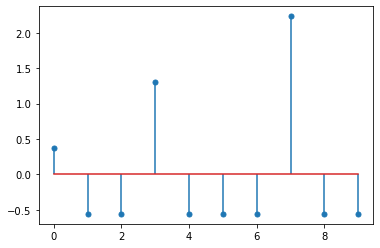

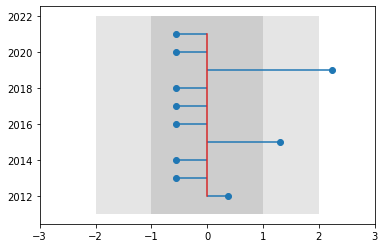

In [69]:
# Add features
# - Highlight the current year
# - Color lines based on higher/lower (red/blue) than average
# - Transparency or hue based on degree of deviation (darker for larger deviations)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

values = [get_std_score(district.season_data, year, 'all_count') for year in i]

# plt.stem(
#     i, values,
#     label = values,
#     bottom=0,
#     orientation='horizontal'
# )
(markers, stemlines, baseline) = plt.stem(values)
fig, ax = plt.subplots(1)

plt.setp(markers, marker='.', markersize=10)
plt.axis([-3, 3, None, None])
# # plt.show()

# Create a Rectangle patch
rect = patches.Rectangle((-1, 2011), 2, 11, facecolor="black", alpha=0.1)
rect2 = patches.Rectangle((-2, 2011), 4, 11, facecolor="black", alpha=0.1)
# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect2)
ax.stem(i, values, bottom=0, orientation='horizontal')

# ax.add_patch(rect)
plt.show()
# plt.show()
# (markers, stemlines, baseline) = plt.stem(values)
# plt.setp(markers, marker='.', markersize=10)
# plt.show()
# fig, ax = plt.subplots()

# ax.plot(values, i)

In [ ]:
# Run time: 16 seconds (can we do better?)
df = make_df(data, dates)

country = Country(df)
country.region_summary(regions)
country.region_data

# regions, districts = get_regions_and_districts(country)

country.region_summary(regions)
country.district_summary(districts)
print(country.region_data)
print(country.district_data)

# region = Region(country, 19)
# district = District(region, 5)

# print(region.season_data)
# print(district.std_scores)

In [ ]:
# output.py
import time
from datetime import datetime as dt
from pandas import DataFrame, ExcelWriter, read_csv

def get_data(country, dates):
    print(country)
    data = send_request(country, dates, print_q=False)
    time.sleep(1)
    return data


def format_adm1_out(data, drop_threshold):
    df = DataFrame(
        data,
        columns=['country', 'adm1', 'significance', 'current_alerts']
    )
    df['score'] = df.significance * df.current_alerts
    return df[df['current_alerts'] > drop_threshold]


def format_adm2_out(data, drop_threshold):
    df = DataFrame(
        data,
        columns=['country', 'adm1', 'adm2', 'significance', 'current_alerts']
    )
    df['score'] = df.significance * df.current_alerts
    return df[df['current_alerts'] > drop_threshold]


def rank_output(df, top_n):
    top_sig = df.sort_values(['significance'], ascending=False).head(top_n)
    top_score = df.sort_values(['score'], ascending=False).head(top_n)
    return top_sig, top_score


def write_results(top_sig, top_score, top_n, adm_level):
    print('Writing results...', end="")
    today = dt.today().date()
    filename = f'{adm_level}_top_{top_n}_output_' + today.strftime('%Y%m%d') + '.xlsx'
    writer = ExcelWriter(filename, engine='xlsxwriter')
    top_sig.to_excel(writer, sheet_name='top_significance', index=False)
    top_score.to_excel(writer, sheet_name='top_score', index=False)
    writer.save()


def all_adm1_significance(iso_list, days=7, drop_threshold=10, top_n=20):
    adm1_out = []
    adm2_out = []
    dates = date_list(days)
    for country in iso_list:
        data = get_data(country, dates)
        if data:
            df = make_df(data, dates)
            regions = df.adm1.unique()
            for region in regions:
                districts = df[df['adm1']==region].adm2.unique()
                adm1_out.append(adm1_significance(df, region))
                for district in districts:
                    adm2_out.append(adm2_significance(df, region, district))
            # out = [significance_tuple(df, region) for region in regions]
            # final_out += out
    adm1_df = format_adm1_out(adm1_out, drop_threshold)
    adm2_df = format_adm2_out(adm2_out, drop_threshold)
    return adm1_df, adm2_df
    # return top_sig, top_score

In [ ]:
adm1_out = []
regions = df.adm1.unique()
for region in regions:
    adm1_out.append(adm1_significance(df, region))
print(adm1_out[:3])
adm1_df = format_adm1_out(adm1_out, drop_threshold=10)
print(adm1_df.head(3))
top_sig, top_score = rank_output(adm1_df, top_n=20)
print(top_sig.head(3))

In [ ]:
def gadm_countries(file='gadm_adm1.csv'):
    keep_cols = ['GID_0', 'NAME_0', 'GID_1', 'NAME_1']
    gadm_df = read_csv(file, usecols=keep_cols)
    iso_list = gadm_df.GID_0.unique()
    return iso_list

In [ ]:
##### End of demo #####

In [ ]:
# iso_list = ['COD', 'IND']
iso_list = gadm_countries()

start = dt.now()
print(f"Start: {start}")

out = all_adm1_significance(iso_list, days=7)

end = dt.now()
print(f"End: {end}")
print(f"Total time: {end - start}")

In [ ]:
out[0].head()

In [ ]:
top_sig, top_score = rank_output(out[0], top_n=20)
write_results(top_sig, top_score, top_n=20, adm_level='adm1')
print("done")
top_sig, top_score = rank_output(out[1], top_n=20)
write_results(top_sig, top_score, top_n=20, adm_level='adm2')
print("done")

In [ ]:
# Add trend of last x days
# Add number of days with at least 1 alert
# Add proportion covered by forest